# How to update graph state from nodes

### State
State in LangGraph can be a TypedDict, Pydantic model, or dataclass. Below we will use TypedDict. See this guide for detail on using Pydantic.

By default, graphs will have the same input and output schema, and the state determines that schema. See this guide for how to define distinct input and output schemas.

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

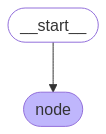

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [9]:
from typing_extensions import Annotated

def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

In [10]:
def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

In [12]:
from langgraph.graph import START

graph = StateGraph(State).add_node(node).add_edge(START,"node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [13]:
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

graph = StateGraph(State).add_node(node).add_edge(START,"node").compile()

In [15]:
input_message = {"role": "user", "content": "Hii"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hii
================================== Ai Message ==================================

Hello!


# How to create a sequence of steps

In [2]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

In [9]:
def step_1(state: State):
    return {"value_1": "a"}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}

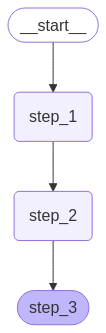

In [10]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

## Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

## Add edges
graph_builder.add_edge(START,"step_1")
graph_builder.add_edge("step_1","step_2")
graph_builder.add_edge("step_2","step_3")

## Compile
graph = graph_builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

### Built-in shorthand

In [12]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START,"step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

# How to create branches for parallel node execution

### How to run graph nodes in parallel
In this example, we fan out from Node A to B and C and then fan in to D. With our state, we specify the reducer add operation. This will combine or accumulate values for the specific key in the State, rather than simply overwriting the existing value.

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

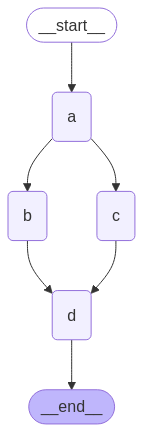

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

In [4]:
def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge(["b_2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

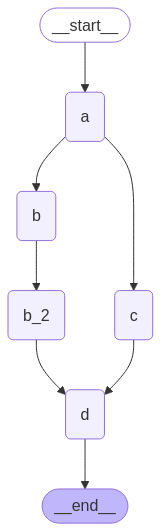

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

### Conditional Branching
If your fan-out is not deterministic, you can use add_conditional_edges directly.

In [7]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

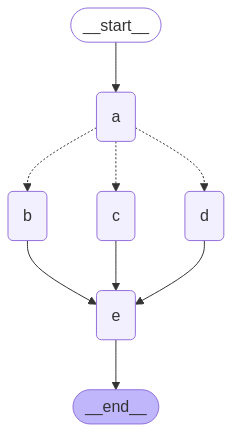

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [10]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

# How to create and control loops

When creating a loop, you can include a conditional edge that specifies a termination condition:

In [ ]:
from typing_extensions import Literal
from langgraph.

In [ ]:
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

def route(state: State) -> Literal["b", END]:
    if termination_condition(state):
        return END
    else:
        return "a"

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

NameError: name 'Literal' is not defined

: 